In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf

import sys
sys.path.append('../../')
from infodenguepredict.data.infodengue import get_cases_table, get_alerta_table


In [2]:
CITY = 3106200

Load data:

In [3]:
%%time
df = get_cases_table(CITY).rename(columns = {'casos':'y'})
#df.set_index('ds', inplace = True)
#df.index = pd.to_datetime(df.index)

df.y = np.log(df.y)

df = df.fillna(0)

df.replace([np.inf, -np.inf], 0, inplace=True)

df.head()

CPU times: user 118 ms, sys: 21.4 ms, total: 139 ms
Wall time: 5.31 s


,y
data_iniSE,
2010-01-03,5.826000
2010-01-10,6.194405
2010-01-17,6.375025
2010-01-24,6.805723
2010-01-31,7.038784


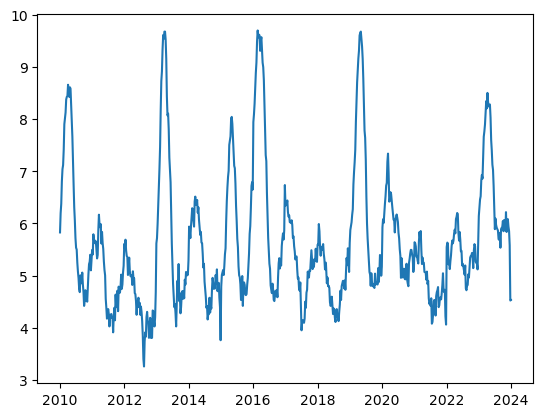

In [4]:
plt.plot(df.y)

/opt/homebrew/Caskroom/miniforge/base/envs/alerta_dengue/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


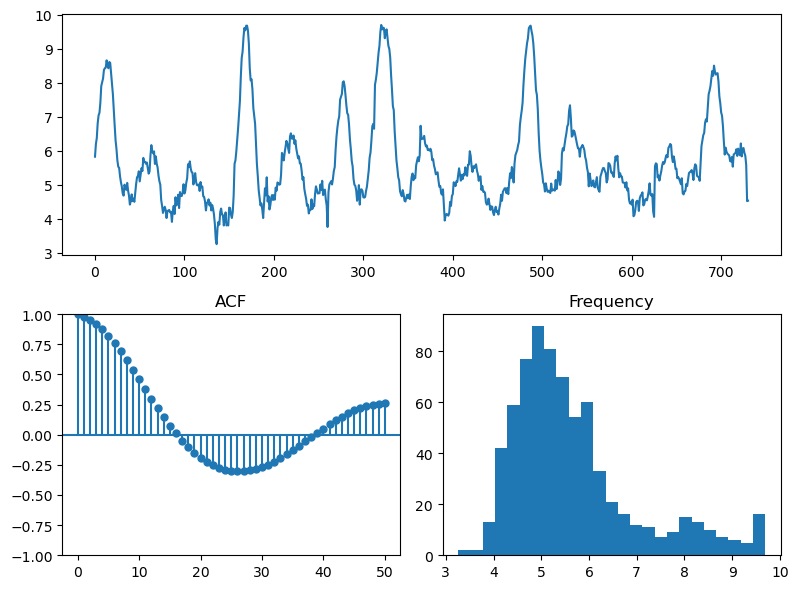

In [5]:
tsdisplay(df)

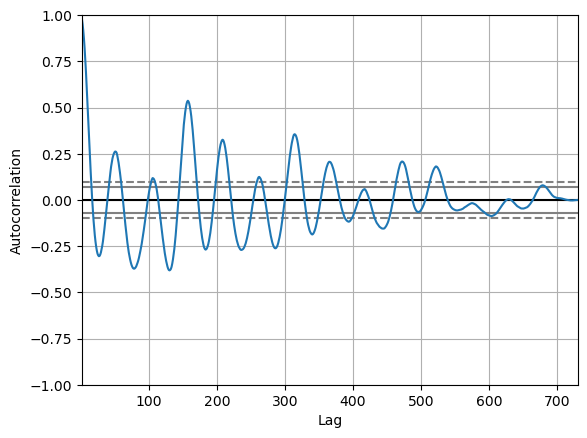

In [6]:
autocorr_plot(df)

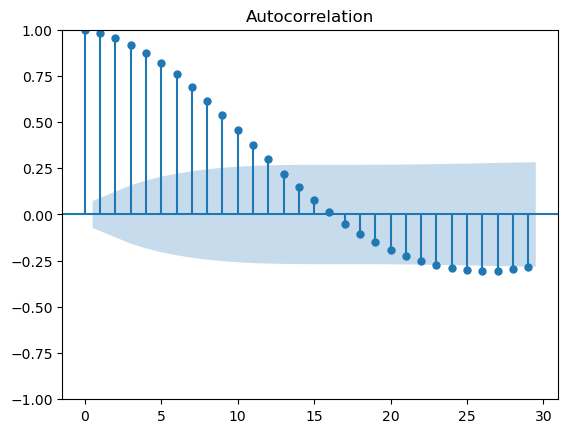

In [7]:
plot_acf(df, alpha = 0.05)

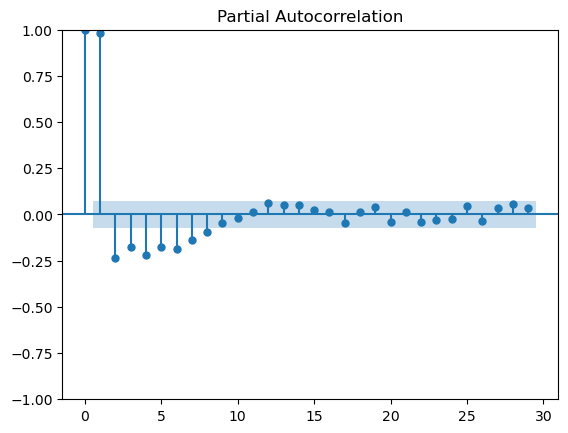

In [8]:
plot_pacf(df, alpha = 0.05)

### Separando os dados em treino e teste: 

In [9]:
df_train = df.loc['2016-01-01':'2021-12-31']

df_train

,y
data_iniSE,
2016-01-03,7.939872
2016-01-10,8.088869
2016-01-17,8.291045
2016-01-24,8.597851
2016-01-31,8.882392
...,...
2021-11-28,4.709530
2021-12-05,4.682131
2021-12-12,4.727388


In [10]:
df_test = df.loc['2021-12-31':]

df_test

,y
data_iniSE,
2022-01-02,5.545177
2022-01-09,5.631212
2022-01-16,5.609472
2022-01-23,5.214936
2022-01-30,5.273000
...,...
2023-12-03,5.937536
2023-12-10,5.852202
2023-12-17,5.579730


Auto tunning do modelo ARIMA

In [11]:
%%time
stepwise=auto_arima(df_train, 
                    start_p=6,
                    start_q=6,
                    start_d=2,
                    max_p=12,
                    max_q=12,
                    max_d=5,
                    max_order=12,
                    seasonal=False,
                    trace=True,
                    maxiter = 100, 
                    error_action='ignore',
                    information_criterion = 'aic',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.808, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-45.891, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-32.213, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-52.969, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-63.898, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-73.395, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-78.599, Time=0.08 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-76.799, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-76.765, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-76.700, Time=0.12 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-74.797, Time=0.09 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=-80.482, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-75.222, 

In [12]:
stepwise

ARIMA(maxiter=100, order=(5, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [13]:
print(stepwise.aic())
print(stepwise.bic())

-80.48181813674438
-58.02379900988748


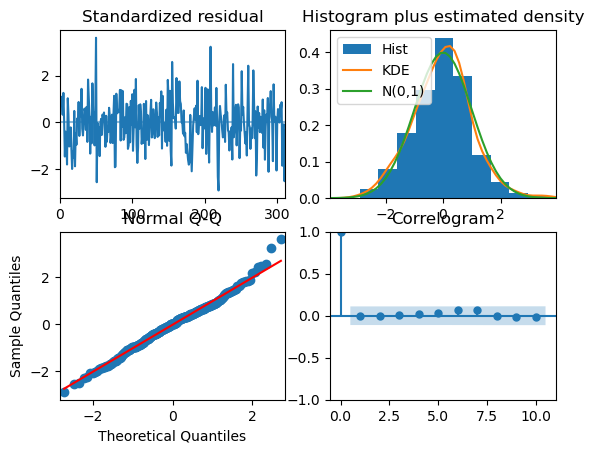

In [14]:
stepwise.plot_diagnostics();

Fit do modelo:

In [15]:
%%time
stepwise.fit(df_train)

CPU times: user 156 ms, sys: 23.8 ms, total: 180 ms
Wall time: 56.3 ms


ARIMA(maxiter=100, order=(5, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Performance in sample do modelo:

In [19]:
df_in_sample = pd.DataFrame()

preds_in_sample = stepwise.predict_in_sample(return_conf_int=True)

df_in_sample['date'] = df_train.index

df_in_sample[['lower', 'upper']] = preds_in_sample[1]

df_in_sample['pred'] = preds_in_sample[0]

df_in_sample = df_in_sample.iloc[1:]

In [20]:
df_in_sample

,date,lower,upper,pred
1,2016-01-10,7.489653,8.390091,7.939872
2,2016-01-17,7.693094,8.562366,8.127730
3,2016-01-24,7.926069,8.787418,8.356743
4,2016-01-31,8.285720,9.128535,8.707127
5,2016-02-07,8.598516,9.425392,9.011954
...,...,...,...,...
308,2021-11-28,4.685583,5.502746,5.094165
309,2021-12-05,4.306855,5.124018,4.715436
310,2021-12-12,4.334879,5.152042,4.743460
311,2021-12-19,4.332667,5.149830,4.741248


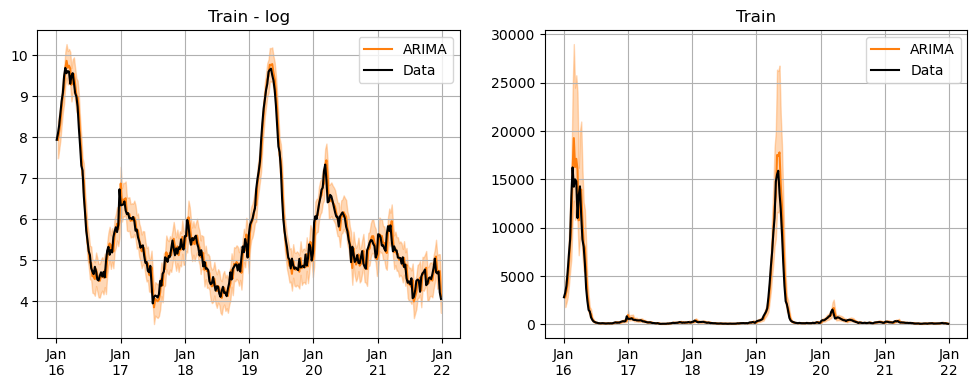

In [21]:
fig,ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(df_in_sample.date, df_in_sample.pred, color = 'tab:orange', label = 'ARIMA')

ax[0].fill_between(df_in_sample.date, df_in_sample.lower, df_in_sample.upper, color = 'tab:orange', alpha = 0.3)

ax[0].plot(df_train.y, color = 'black', label = 'Data')

ax[0].legend()

ax[0].grid()

#ax[0].set_ylim([0, max(df_in_sample.pred) + 10])

ax[0].set_title('Train - log')

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))

ax[1].plot(df_in_sample.date, np.exp(df_in_sample.pred), color = 'tab:orange', label = 'ARIMA')

ax[1].fill_between(df_in_sample.date, np.exp(df_in_sample.lower), np.exp(df_in_sample.upper), color = 'tab:orange', alpha = 0.3)

ax[1].plot(np.exp(df_train.y), color = 'black', label = 'Data')

ax[1].legend()

ax[1].grid()

ax[1].set_title('Train')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))


plt.show()

**Rolling fashion** to eval the performance out of sample predicting 4 weeks ahead. **After each prediction the model is updated with the new data:**

In [22]:
def rolling_window(model, df):
    
    preds = []
    preds_lower = []
    preds_upper = [] 
    
    for n in np.arange(0, df.shape[0]-4):
        
        p = model.update(df.iloc[n]).predict(4,return_conf_int = True)
        
        preds.append(p[0][-1])
        preds_lower.append(p[1][:,0][-1])
        preds_upper.append(p[1][:,1][-1])
        
    df_preds = pd.DataFrame()
    
    df_preds['dates'] = df.index[4:]
    
    df_preds['preds_lower'] = preds_lower
    
    df_preds['preds'] = preds
    
    df_preds['preds_upper'] = preds_upper
        
    return df_preds
    

In [23]:
df_preds = rolling_window(stepwise, df_test)

df_preds

,dates,preds_lower,preds,preds_upper
0,2022-01-30,4.995333,6.021857,7.048381
1,2022-02-06,5.165289,6.181201,7.197112
2,2022-02-13,5.330582,6.350206,7.369830
3,2022-02-20,4.618121,5.635140,6.652159
4,2022-02-27,4.394759,5.414281,6.433802
...,...,...,...,...
96,2023-12-03,5.334374,6.342690,7.351007
97,2023-12-10,4.755897,5.763094,6.770290
98,2023-12-17,5.106960,6.112117,7.117273
99,2023-12-24,5.111697,6.115377,7.119058


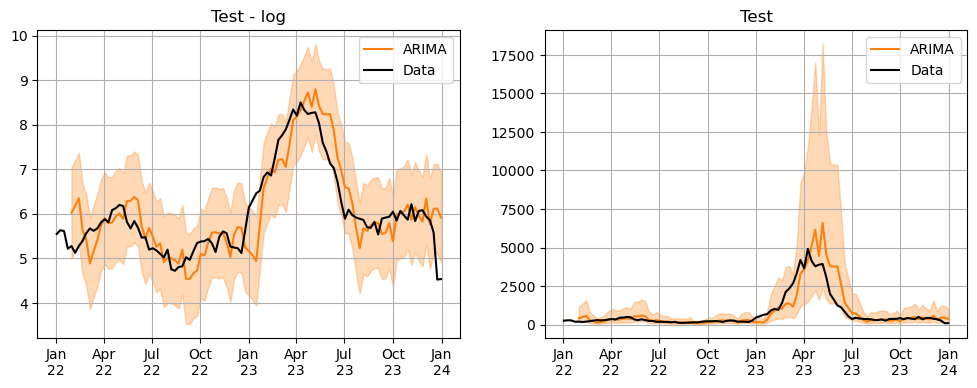

In [24]:
fig,ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(df_preds.dates, df_preds.preds, color = 'tab:orange', label = 'ARIMA')

ax[0].fill_between(df_preds.dates, df_preds.preds_lower, df_preds.preds_upper, color = 'tab:orange', alpha = 0.3)

ax[0].plot(df_test.y, color = 'black', label = 'Data')

ax[0].legend()

ax[0].grid()

ax[0].set_title('Test - log')

ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))

ax[1].plot(df_preds.dates, np.exp(df_preds.preds), color = 'tab:orange', label = 'ARIMA')

ax[1].fill_between(df_preds.dates, np.exp(df_preds.preds_lower), np.exp(df_preds.preds_upper), color = 'tab:orange', alpha = 0.3)

ax[1].plot(np.exp(df_test.y), color = 'black', label = 'Data')

ax[1].legend()

ax[1].grid()

ax[1].set_title('Test')

ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))


plt.show()